# **Desafio de Séries Temporais:**

**Nome:** Gustavo Bartholomeu Trad Souza

**Nº USP:** 11219216

**Disciplina:** SCC0277 - Competições de Ciências de Dados

**Docente:** Fernando Pereira dos Santos

**Universidade de São Paulo (USP)**

Utilizando a metodologia básica de um projeto para ciência de dados, implemente possíveis soluções para o seguinte estudo de caso (https://www.kaggle.com/datasets/sumanthvrao/daily-climate-time-series-data). Desenvolva e implemente métodos que se propõem a estimar a variável de saída.

Em seu projeto deverá constar uma análise detalhada do dataset e descrição das transformações de dados realizadas com suas respectivas justificativas. Adicionalmente, crie um baseline com as técnicas contidas nesta aula. Como forma de superar este baseline, pesquise por métodos e técnicas mais complexas. Você deverá entregar um relatório com os seguintes itens:
- Descrição do problema e análise dos dados
- Descrição das técnicas utilizadas
- Interpretação dos resultados obtidos
- Conclusão
- Apêndice (descrição das técnicas de Séries Temporais apresentadas pelos colegas durante os seminários)

Adicionalmente, no relatório coloque a url de seu repositório on-line para consulta. Seu código deve estar comentado!!

Sistema de Avaliação:
- (1,0) Qualidade do relatório
- (1,0) Análise dos dados e descrição do problema
- (3,0) Implementação da solução
- (3,0) Interpretação dos resultados
- (2,0) Resumo das técnicas dos seminários de Regressão

In [ ]:
!pip install sktime
!pip install sktime[all_extras]
!pip install prophet

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

from sktime.utils.plotting import plot_series
from sktime.forecasting.arima import AutoARIMA
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error, mean_squared_percentage_error

from prophet import Prophet

from datetime import datetime, date, timedelta

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


---
# **1. Descrição do problema e análise dos dados**
O dataset do problema é composto por dois arquivos:
* O arquivo **DailyDelhiClimateTrain.csv** contém dados meteorológicos coletados na cidade de Delhi, na Índia, no período de 4 anos (de 2013 a 2017) e será usado como dataset para treinamento dos modelos de séries temporais.
* O arquivo **DailyDelhiClimateTest.csv** contém dados meteorológicos coletados na cidade de Delhi, na Índia, no período de 4 meses (do ano de 2017) e será usado como dataset para teste dos modelos de séries temporais.

O objetivo é adaptar algoritimos para prever os valores do dataset de teste através do seu treinamento com os valores presentres no dataset de treino.

## **1.1. Descrição dos dados**

Ambos os arquivos possuem as mesmas colunas, sendo elas:
* **date**: Data de coleta do dado no formato YYYY-MM-DD.
* **meantemp**: Temperatura média calculada a partir de múltiplos intervalos de 3 horas em um dia.
* **humidity**: Valor de umidade para o dia (gramas de vapor de água por metro cúbico de volume de ar - g/m³).
* **wind_speed**: Velocidade medida do vento em km/h.
* **meanpressure**: Leitura de pressão do clima (medida em atm)

In [ ]:
train_data = pd.read_csv('DailyDelhiClimateTrain.csv')
test_data = pd.read_csv('DailyDelhiClimateTest.csv')

In [ ]:
train_max = train_data.max(axis=0)
train_min = train_data.min(axis=0)
train_mean = train_data.mean(axis=0, numeric_only=True)

## **1.2. Preparação do dataset**
###**Valores faltantes**:
Ambos os conjuntos de dados não possuem valores ausentes, portanto não será necessário utilizar técnicas de substituição. No caso de haver valores ausentes, uma abordagem adequada seria calcular a média entre os valores imediatamente anteriores e posteriores ao valor ausente. Dessa forma, a relação temporal entre os dados seria levada em consideração, o que não aconteceria se fosse feita uma substituição pela média global, por exemplo.

###**Outliers**:
Os outliers (valores cujo z-score em relação à coluna é maior que 1.5) serão substituidos pela média entre os valores imediatamente anterior e imediatamnete posterior àquele valor caso ambos os valores existam ou pela média da coluna  no dataset de treino caso contrário.

###**Intervalo entre os dados**:
Serão gerados dois conjuntos à partir de cada dataset, um dos conjuntos terá um intervalo de 1 dia entre dados consecultivos (frequência do dataset original) e o outro dataset terá um intervalo de 2 dias (metade dos elementos serão removidos de forma intercalada), a fim de testar se um undersampling pode melhorar no aprendizado uma vez que pode reduzir o ruído e fortalecer tendências e sazonalidades de longo prazo.

###**Normalização**:
Será realizada uma normalização min-max com os valores máximo e minimo do dataset de treino sendo usado em ambos os datasets, a fim de reduzir a escala dos atributos e facilitar o ajuste dos algoritimos.


In [ ]:
# função que prepara o dataset
def prepare_data(dataframe, resample=None, print_info=False):
  # copia o dataframe para evitar que o objeto original seja alterado
  df = dataframe.copy()
  # faz o casting da coluna de data para DateTime
  df['date'] = pd.to_datetime(df['date'])

  # transforma a coluna de data na coluna index do dataset
  df.set_index('date', inplace=True)

  # Define a frequencia como sendo diária
  df = df.asfreq(freq='D')

  for col in df.columns:
    # obtem as linhas com outlier na coluna
    outliers = df.loc[np.abs(stats.zscore(df[col])) >= 1.5, col]

    # substitui os outliers pela média do posterior e anterior caso existam ou pela media da coluna de treino caso o anterior ou posterior não existam
    for idx in outliers.index:
      before = idx - timedelta(days=1)
      after = idx + timedelta(days=1)
      df.loc[idx, col] = (df.loc[before, col] + df.loc[after, col])/2 if (before in df.index) and (after in df.index) else train_mean[col]

    # normalização min-max com o maximo e minimo do dataset de treino
    df[col] = (df[col] - train_min[col]) / (train_max[col] - train_min[col])


  # faz o resample casouma nova frequencia seja passada
  if resample is not None: df = df.resample(resample).asfreq()
  if print_info: df.info()

  return df

In [ ]:
print('Descrição do dataset de treino - frequência diária:\n')
y_train_1D = prepare_data(dataframe=train_data, print_info=True)
print('\n-------------------\n')
print('Descrição do dataset de treino - frequência 2 dias:\n')
y_train_2D = prepare_data(dataframe=train_data, resample='2D',  print_info=True)
print('\n-------------------\n')
print('Descrição do dataset de treino - frequência 4 dias:\n')
y_train_4D = prepare_data(dataframe=train_data, resample='4D',  print_info=True)

Descrição do dataset de treino - frequência diária:

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1462 entries, 2013-01-01 to 2017-01-01
Freq: D
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   meantemp      1462 non-null   float64
 1   humidity      1462 non-null   float64
 2   wind_speed    1462 non-null   float64
 3   meanpressure  1462 non-null   float64
dtypes: float64(4)
memory usage: 89.4 KB

-------------------

Descrição do dataset de treino - frequência 2 dias:

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 731 entries, 2013-01-01 to 2016-12-31
Freq: 2D
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   meantemp      731 non-null    float64
 1   humidity      731 non-null    float64
 2   wind_speed    731 non-null    float64
 3   meanpressure  731 non-null    float64
dtypes: float64(4)
memory usage: 28.6 KB

---------

In [ ]:
print('Descrição do dataset de teste - frequência diária:\n')
y_test_1D  = prepare_data(dataframe=test_data, print_info=True)
print('\n-------------------\n')
print('Descrição do dataset de teste - frequência 2 dias:\n')
y_test_2D  = prepare_data(dataframe=test_data, resample='2D', print_info=True)
print('\n-------------------\n')
print('Descrição do dataset de teste - frequência 4 dias:\n')
y_test_4D  = prepare_data(dataframe=test_data, resample='4D', print_info=True)

Descrição do dataset de teste - frequência diária:

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 114 entries, 2017-01-01 to 2017-04-24
Freq: D
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   meantemp      114 non-null    float64
 1   humidity      114 non-null    float64
 2   wind_speed    114 non-null    float64
 3   meanpressure  114 non-null    float64
dtypes: float64(4)
memory usage: 8.5 KB

-------------------

Descrição do dataset de teste - frequência 2 dias:

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 57 entries, 2017-01-01 to 2017-04-23
Freq: 2D
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   meantemp      57 non-null     float64
 1   humidity      57 non-null     float64
 2   wind_speed    57 non-null     float64
 3   meanpressure  57 non-null     float64
dtypes: float64(4)
memory usage: 2.2 KB

---------------

In [ ]:
print('Descrição do dataset completo - frequência diária:\n')
y_1D = pd.concat([y_train_1D, y_test_1D], ignore_index=False)
y_1D.info()
print('\n-------------------\n')
print('Descrição do dataset completo - frequência 2 dias:\n')
y_2D = pd.concat([y_train_2D, y_test_2D], ignore_index=False)
y_2D.info()
print('\n-------------------\n')
print('Descrição do dataset completo - frequência 4 dias:\n')
y_4D = pd.concat([y_train_4D, y_test_4D], ignore_index=False)
y_4D.info()

Descrição do dataset completo - frequência diária:

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1576 entries, 2013-01-01 to 2017-04-24
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   meantemp      1576 non-null   float64
 1   humidity      1576 non-null   float64
 2   wind_speed    1576 non-null   float64
 3   meanpressure  1576 non-null   float64
dtypes: float64(4)
memory usage: 61.6 KB

-------------------

Descrição do dataset completo - frequência 2 dias:

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 788 entries, 2013-01-01 to 2017-04-23
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   meantemp      788 non-null    float64
 1   humidity      788 non-null    float64
 2   wind_speed    788 non-null    float64
 3   meanpressure  788 non-null    float64
dtypes: float64(4)
memory usage: 30.8 KB

-------------------

Descriç

Dados sem tratamento: 


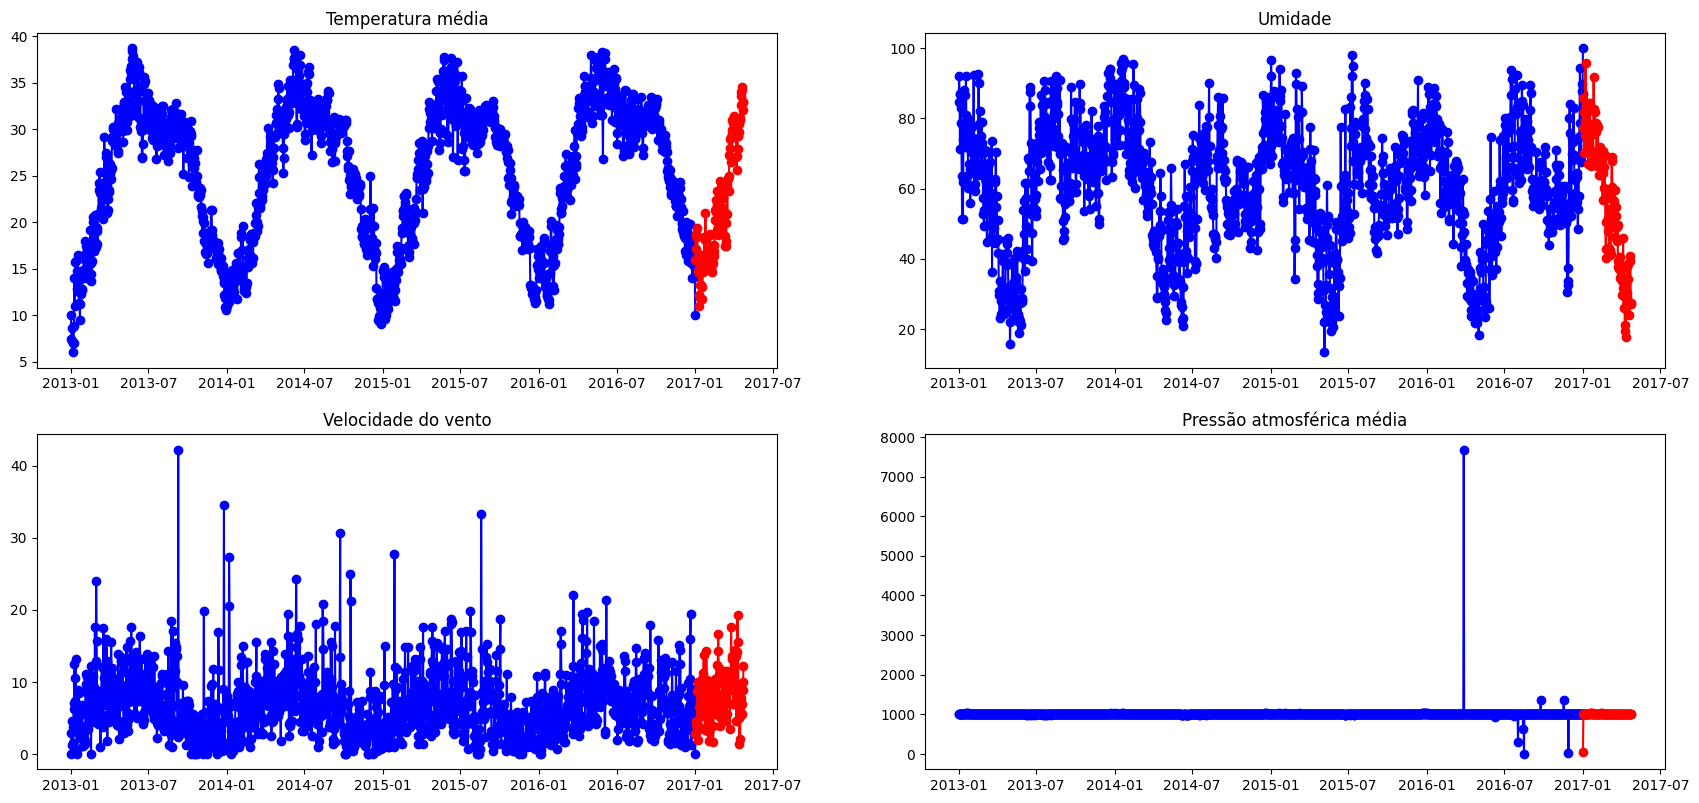

In [ ]:
def create_subplot(train_data, test_data, position, title, figure):
  plot = figure.add_subplot(position)
  plot.title.set_text(title)
  plt.plot(train_data.index, train_data, '-o', c='b', label="y_train")
  plt.plot(test_data.index, test_data, '-o', c='r', label="y_test")

print("Dados sem tratamento: ")
fig1 = plt.figure(figsize=(21, 20))

train_raw = train_data.copy()
train_raw['date'] = pd.to_datetime(train_raw['date'])
train_raw.set_index('date', inplace=True)

test_raw = test_data.copy()
test_raw['date'] = pd.to_datetime(test_raw['date'])
test_raw.set_index('date', inplace=True)

create_subplot(train_raw['meantemp'], test_raw['meantemp'], 421, 'Temperatura média', fig1)
create_subplot(train_raw['humidity'], test_raw['humidity'], 422, 'Umidade', fig1)
create_subplot(train_raw['wind_speed'], test_raw['wind_speed'], 423, 'Velocidade do vento', fig1)
create_subplot(train_raw['meanpressure'], test_raw['meanpressure'], 424, 'Pressão atmosférica média', fig1)

Dados tratados com frquencia de 1 dia:


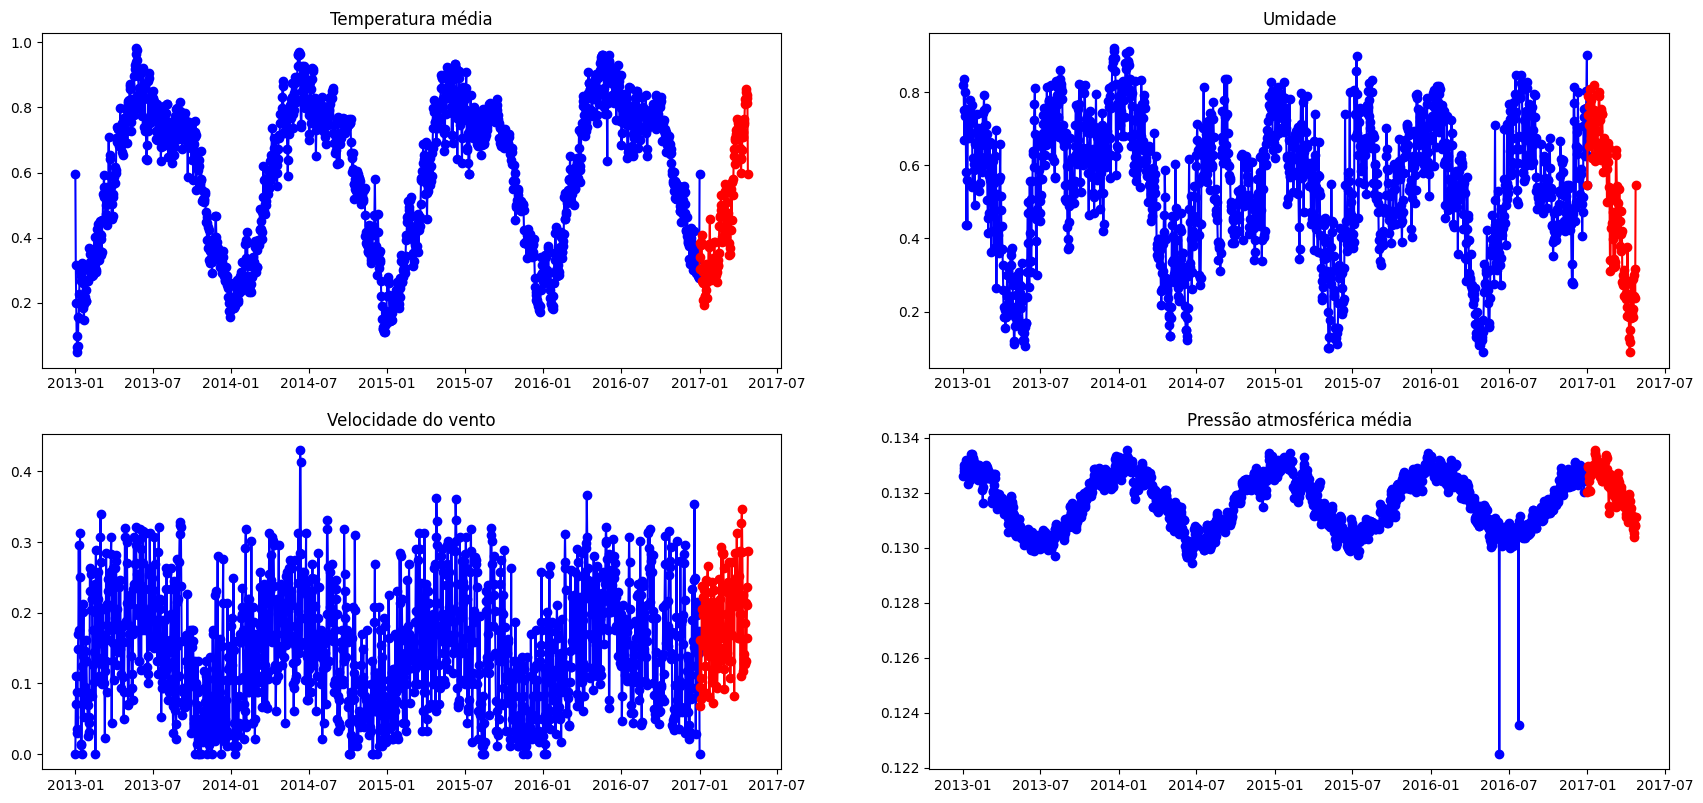

In [ ]:
print("Dados tratados com frquencia de 1 dia:")
fig2 = plt.figure(figsize=(21, 20))
create_subplot(y_train_1D['meantemp'], y_test_1D['meantemp'], 421, 'Temperatura média', fig2)
create_subplot(y_train_1D['humidity'], y_test_1D['humidity'], 422, 'Umidade', fig2)
create_subplot(y_train_1D['wind_speed'], y_test_1D['wind_speed'], 423, 'Velocidade do vento', fig2)
create_subplot(y_train_1D['meanpressure'], y_test_1D['meanpressure'], 424, 'Pressão atmosférica média', fig2)

Dados tratados com frquencia de 2 dias:


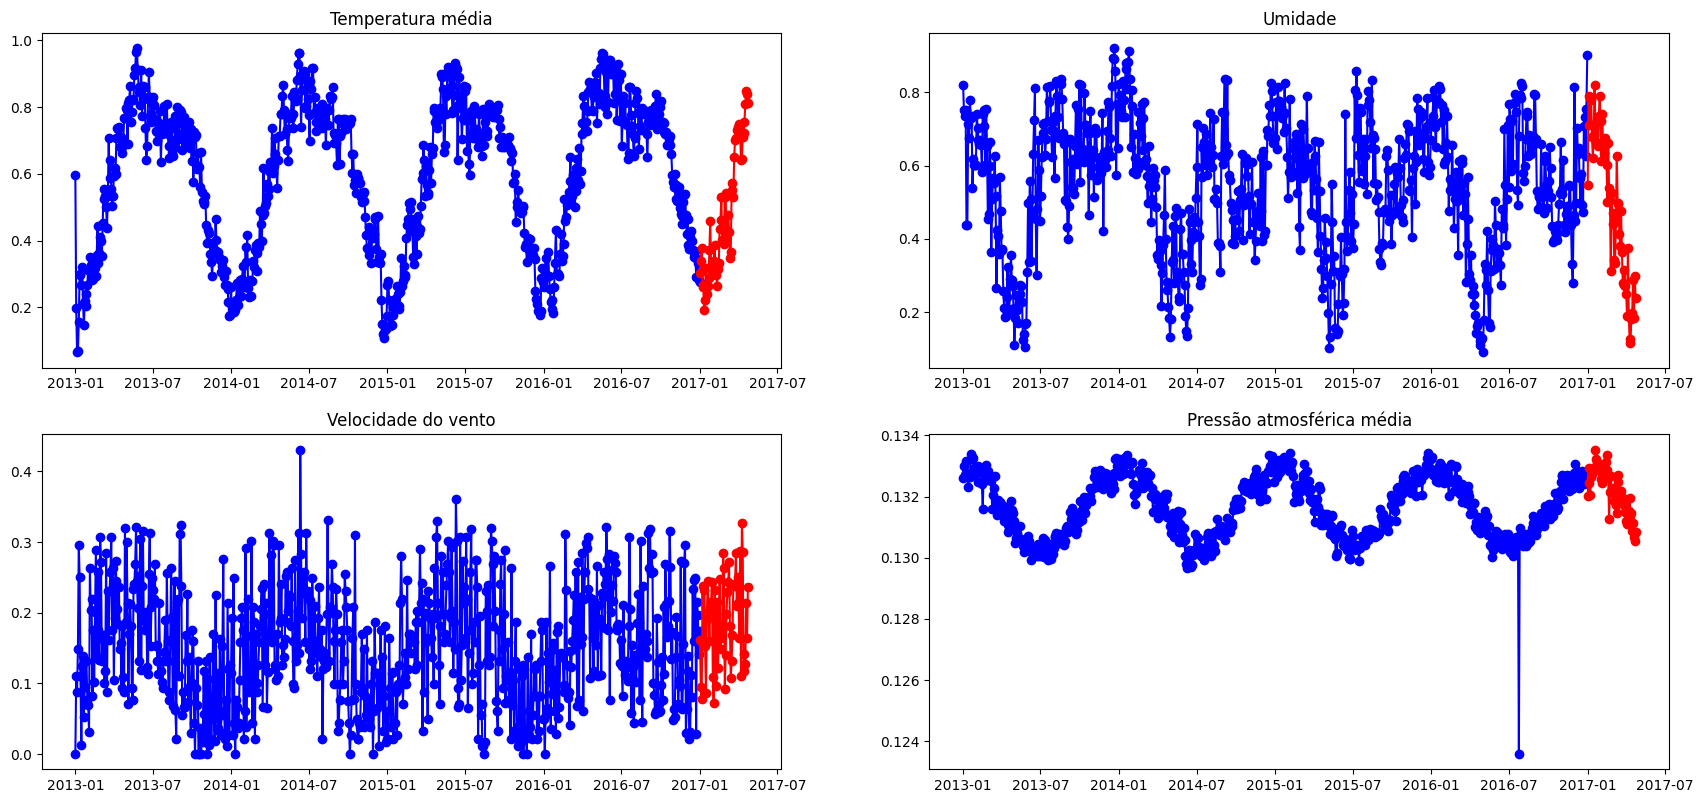

In [ ]:
print("Dados tratados com frquencia de 2 dias:")
fig3 = plt.figure(figsize=(21, 20))
create_subplot(y_train_2D['meantemp'], y_test_2D['meantemp'], 421, 'Temperatura média', fig3)
create_subplot(y_train_2D['humidity'], y_test_2D['humidity'], 422, 'Umidade', fig3)
create_subplot(y_train_2D['wind_speed'], y_test_2D['wind_speed'], 423, 'Velocidade do vento', fig3)
create_subplot(y_train_2D['meanpressure'], y_test_2D['meanpressure'], 424, 'Pressão atmosférica média', fig3)

Dados tratados com frquencia de 4 dias:


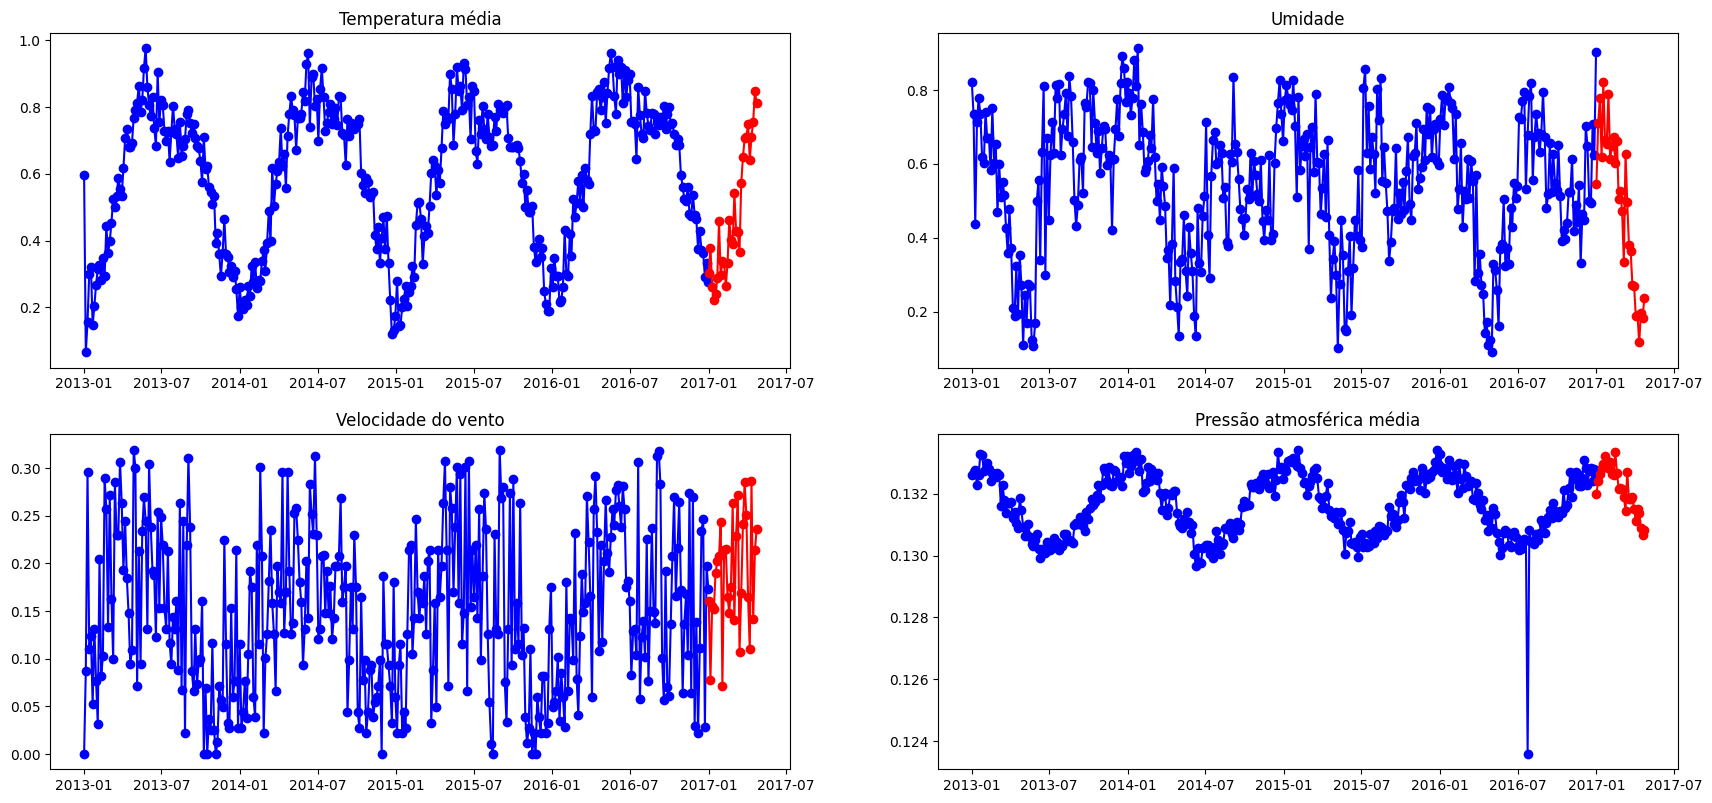

In [ ]:
print("Dados tratados com frquencia de 4 dias:")
fig4 = plt.figure(figsize=(21, 20))
create_subplot(y_train_4D['meantemp'], y_test_4D['meantemp'], 421, 'Temperatura média', fig4)
create_subplot(y_train_4D['humidity'], y_test_4D['humidity'], 422, 'Umidade', fig4)
create_subplot(y_train_4D['wind_speed'], y_test_4D['wind_speed'], 423, 'Velocidade do vento', fig4)
create_subplot(y_train_4D['meanpressure'], y_test_4D['meanpressure'], 424, 'Pressão atmosférica média', fig4)

---
# **2. Descrição das técnicas utilizadas**

**Auto Arima:** Método que otimiza o modelo Arima identificando a melhor configuração de seus hiperparâmetros.

**ARIMA (Auto-Regressive Integrated Moving Average)** - Decompõe a variável observada em componentes de tendência, sazonalidade e irregularidade. Remove a tendência e a sazonalidade, permitindo a modelagem da série estacionária usando componentes auto regressivos (AR) e média móvel (MA).

**Propriedades:**
- Uma série temporal é estacionária se suas propriedades (média e variância, por exemplos) não dependem do tempo da observação. Portanto, séries com tendências ou sazonalidades não são estacionárias.
- Autocorrelação é uma medida do relacionamento linear entre os valores dentro de uma mesma série. Assim, se a série é composta por valores aleatórios, a autocorrelação é praticamente nula.

In [ ]:
def test_autoARIMA(y, y_train, y_test):
  fig = plt.figure(figsize=(21, 20))
  sp = 5
  for i, col in enumerate(y.columns):
    forecaster = AutoARIMA(suppress_warnings=True, sp=sp)
    forecaster.fit(y_train[col])
    y_last = forecaster.predict(np.arange(len(y_test)))

    title = col + " - " + str(sp) + " picos sasonais - MAPE: " + str(mean_absolute_percentage_error(y_test[col], y_last)) + ' / MSPE: ' + str(mean_squared_percentage_error(y_test[col], y_last))
    print('DONE: ' + title)

    create_subplot(y[col], y_last, len(y.columns)*100 + 20 + i + 1, title, fig)

DONE: meantemp - 5 picos sasonais - MAPE: 0.3624294260805139 / MSPE: 0.20000784190683463
DONE: humidity - 5 picos sasonais - MAPE: 0.6096968881899325 / MSPE: 1.086235677268269
DONE: wind_speed - 5 picos sasonais - MAPE: 0.3176432713950525 / MSPE: 0.1336658356045566
DONE: meanpressure - 5 picos sasonais - MAPE: 0.0037042091407261577 / MSPE: 1.9866887019259007e-05


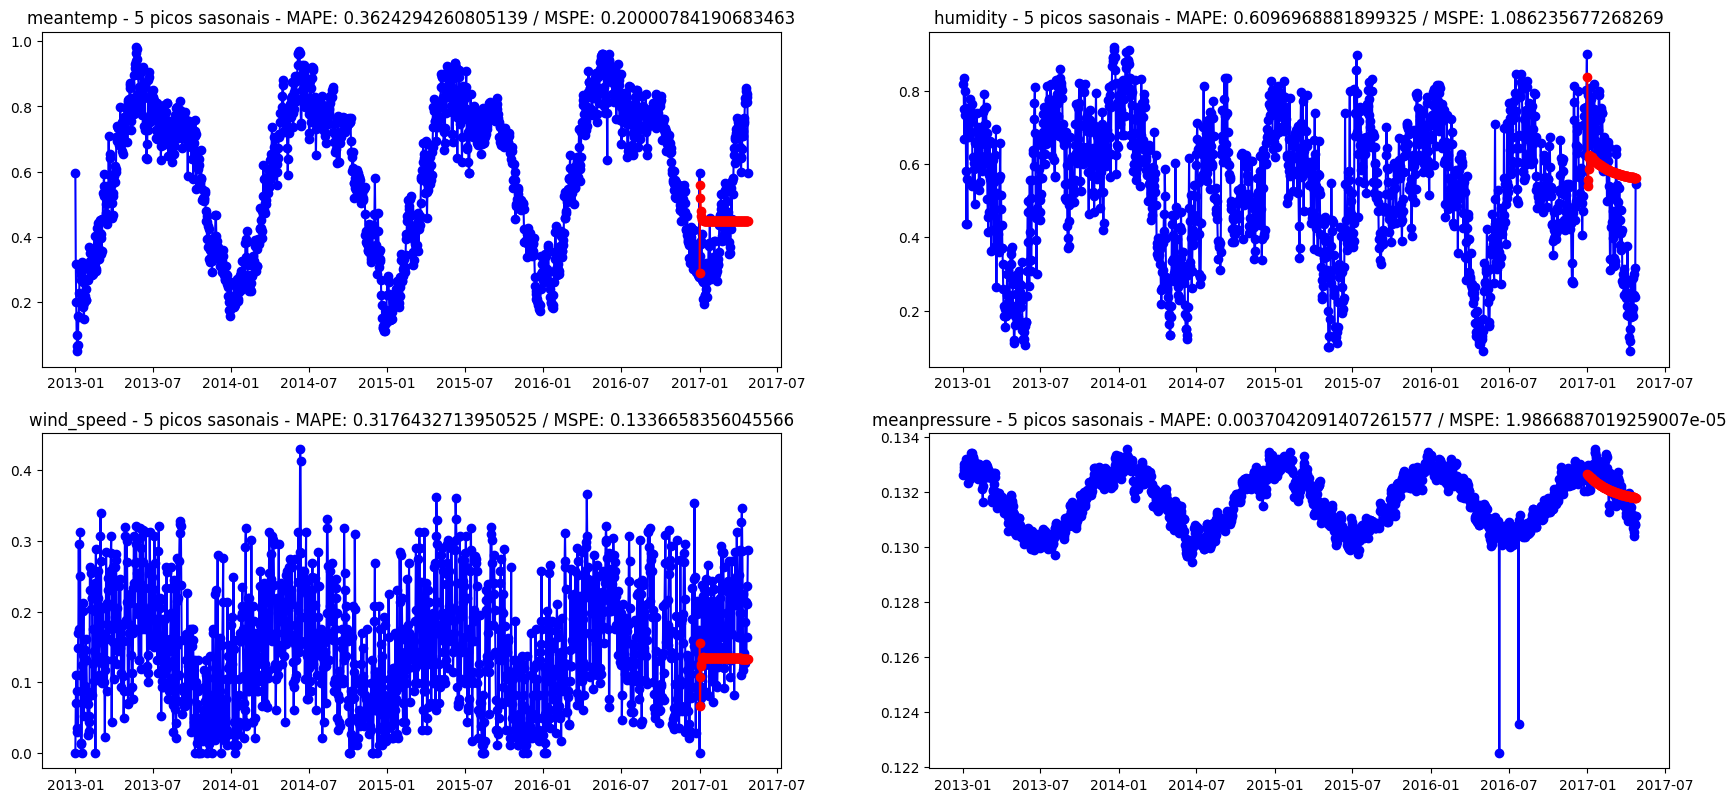

In [ ]:
test_autoARIMA(y_1D, y_train_1D, y_test_1D)

DONE: meantemp - 5 picos sasonais - MAPE: 0.25743432827626245 / MSPE: 0.09387762043538728
DONE: humidity - 5 picos sasonais - MAPE: 0.6133155919582816 / MSPE: 1.0830259656259822
DONE: wind_speed - 5 picos sasonais - MAPE: 0.33051470306055225 / MSPE: 0.1642953282961248
DONE: meanpressure - 5 picos sasonais - MAPE: 0.003661390699348607 / MSPE: 1.963003761603486e-05


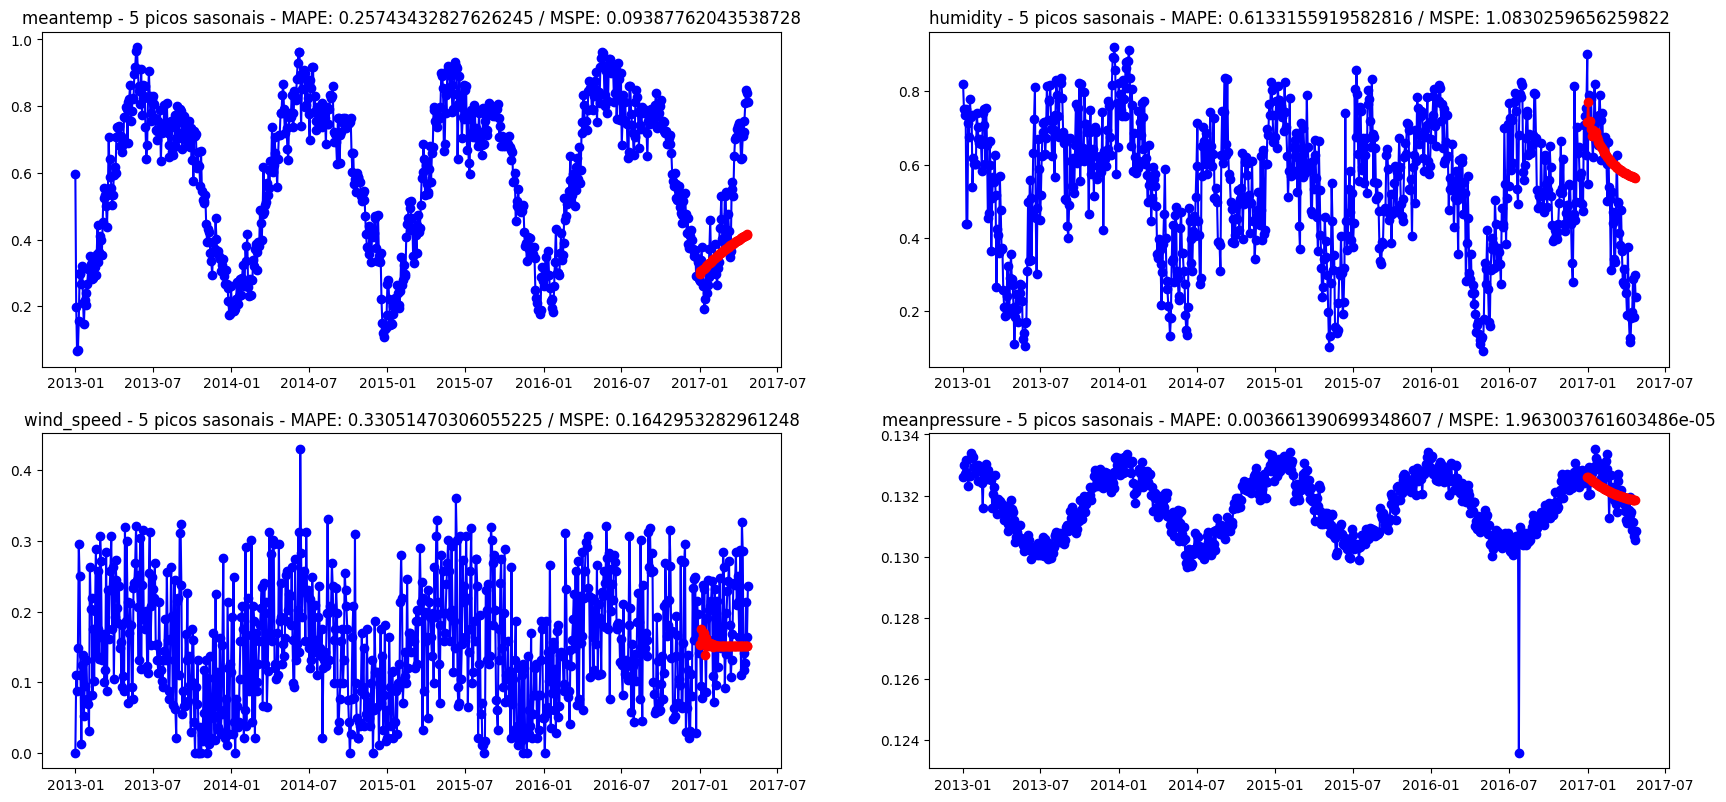

In [ ]:
test_autoARIMA(y_2D, y_train_2D, y_test_2D)

DONE: meantemp - 5 picos sasonais - MAPE: 0.17874528920822547 / MSPE: 0.043995468483553145
DONE: humidity - 5 picos sasonais - MAPE: 0.6813326839147711 / MSPE: 1.3216456163308492
DONE: wind_speed - 5 picos sasonais - MAPE: 0.30345156696473014 / MSPE: 0.1545906209876034
DONE: meanpressure - 5 picos sasonais - MAPE: 0.00427101243470001 / MSPE: 2.6665862945776454e-05


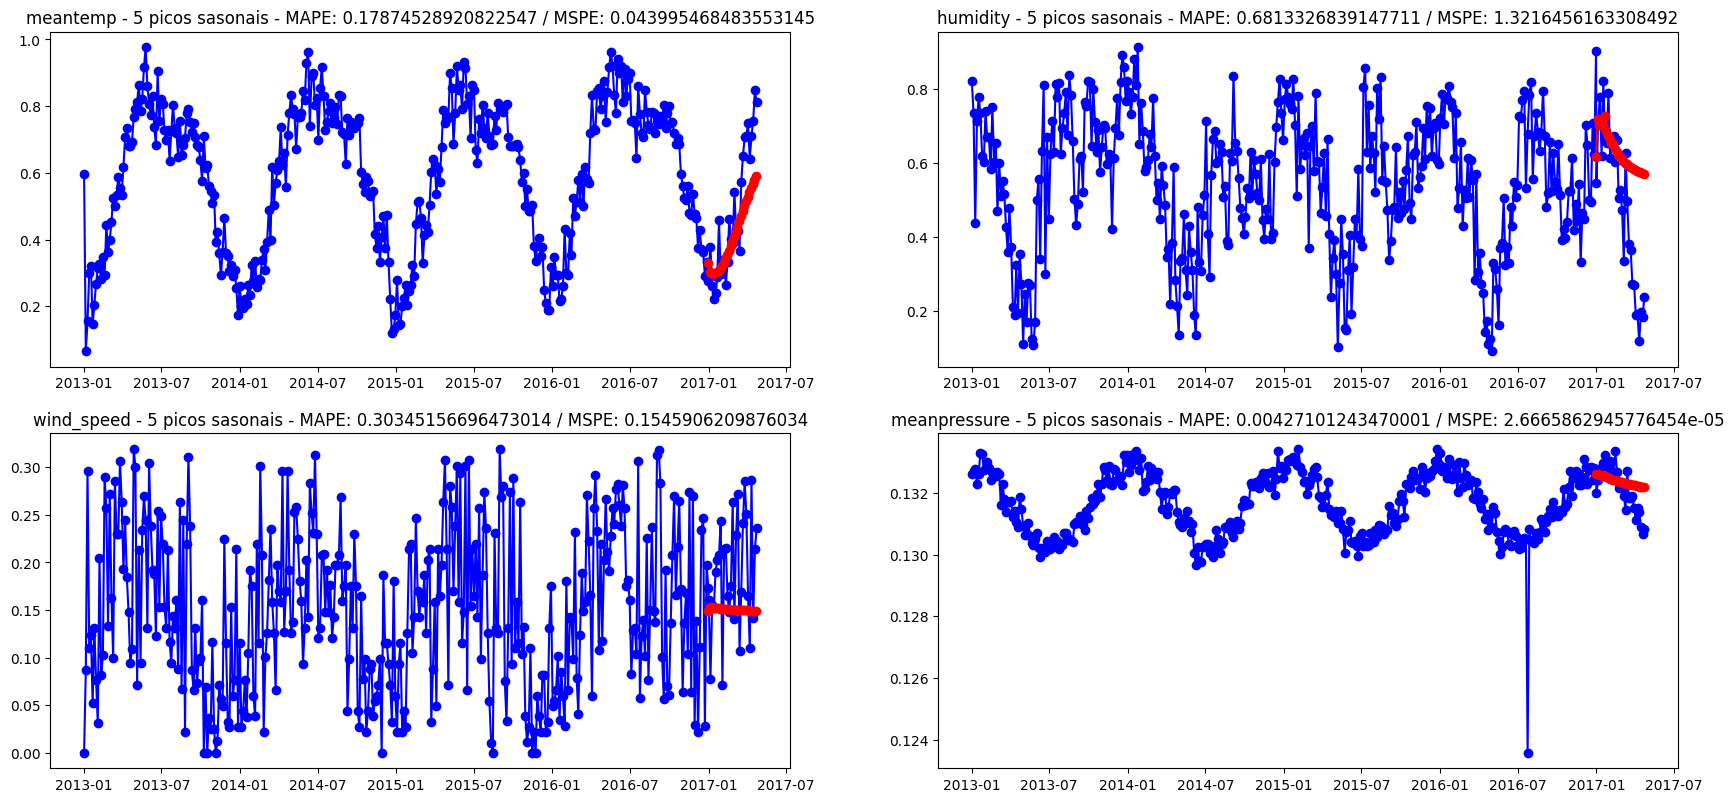

In [ ]:
test_autoARIMA(y_4D, y_train_4D, y_test_4D)

**Exponential Smoothing:** Podemos especificar a tendência ($trend$), a sazonalidade ($seasonal$) e sua quantidade ($sp$)
* tendência: direção dos valores da variável em relação ao tempo
* sazonalidade: qualquer mudança ou padrão previsível, ou seja, repetição de comportamento

In [ ]:
def test_ExpSmoothing(y, y_train, y_test):
  fig = plt.figure(figsize=(21, 20))
  sp = 5
  for i, col in enumerate(y.columns):
    forecaster =  ExponentialSmoothing(trend='add', seasonal='additive', sp=sp)
    forecaster.fit(y_train[col])
    y_last = forecaster.predict(np.arange(len(y_test)))

    title = col + " - " + str(sp) + " picos sasonais - MAPE: " + str(mean_absolute_percentage_error(y_test[col], y_last)) + ' / MSPE: ' + str(mean_squared_percentage_error(y_test[col], y_last))
    print('DONE: ' + title)

    create_subplot(y[col], y_last, len(y.columns)*100 + 20 + i + 1, title, fig)

DONE: meantemp - 5 picos sasonais - MAPE: 0.493213151706601 / MSPE: 0.41449194134433054
DONE: humidity - 5 picos sasonais - MAPE: 0.6250695598136046 / MSPE: 1.1106985271860175
DONE: wind_speed - 5 picos sasonais - MAPE: 0.4946665485937959 / MSPE: 0.28000576651154774
DONE: meanpressure - 5 picos sasonais - MAPE: 0.00884528249338712 / MSPE: 0.00012896554837503793


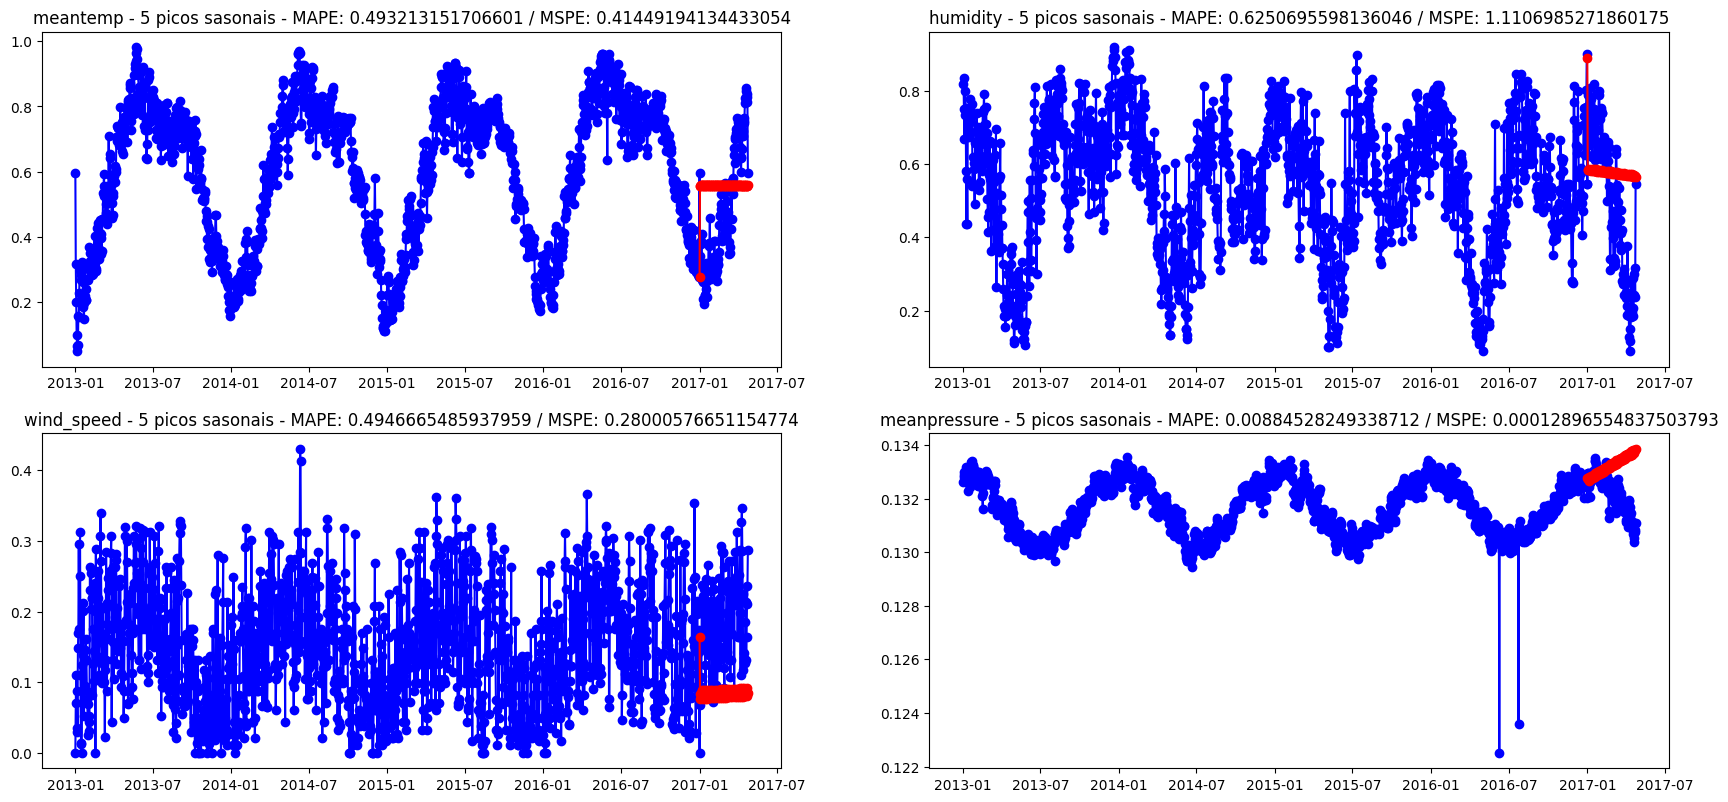

In [ ]:
test_ExpSmoothing(y_1D, y_train_1D,  y_test_1D)

DONE: meantemp - 5 picos sasonais - MAPE: 0.3608017513333269 / MSPE: 0.17660443062185058
DONE: humidity - 5 picos sasonais - MAPE: 1.1157676365045568 / MSPE: 2.9502277485367876
DONE: wind_speed - 5 picos sasonais - MAPE: 0.3159538810489024 / MSPE: 0.15522992926391288
DONE: meanpressure - 5 picos sasonais - MAPE: 0.009273335817924696 / MSPE: 0.00014155813843018365


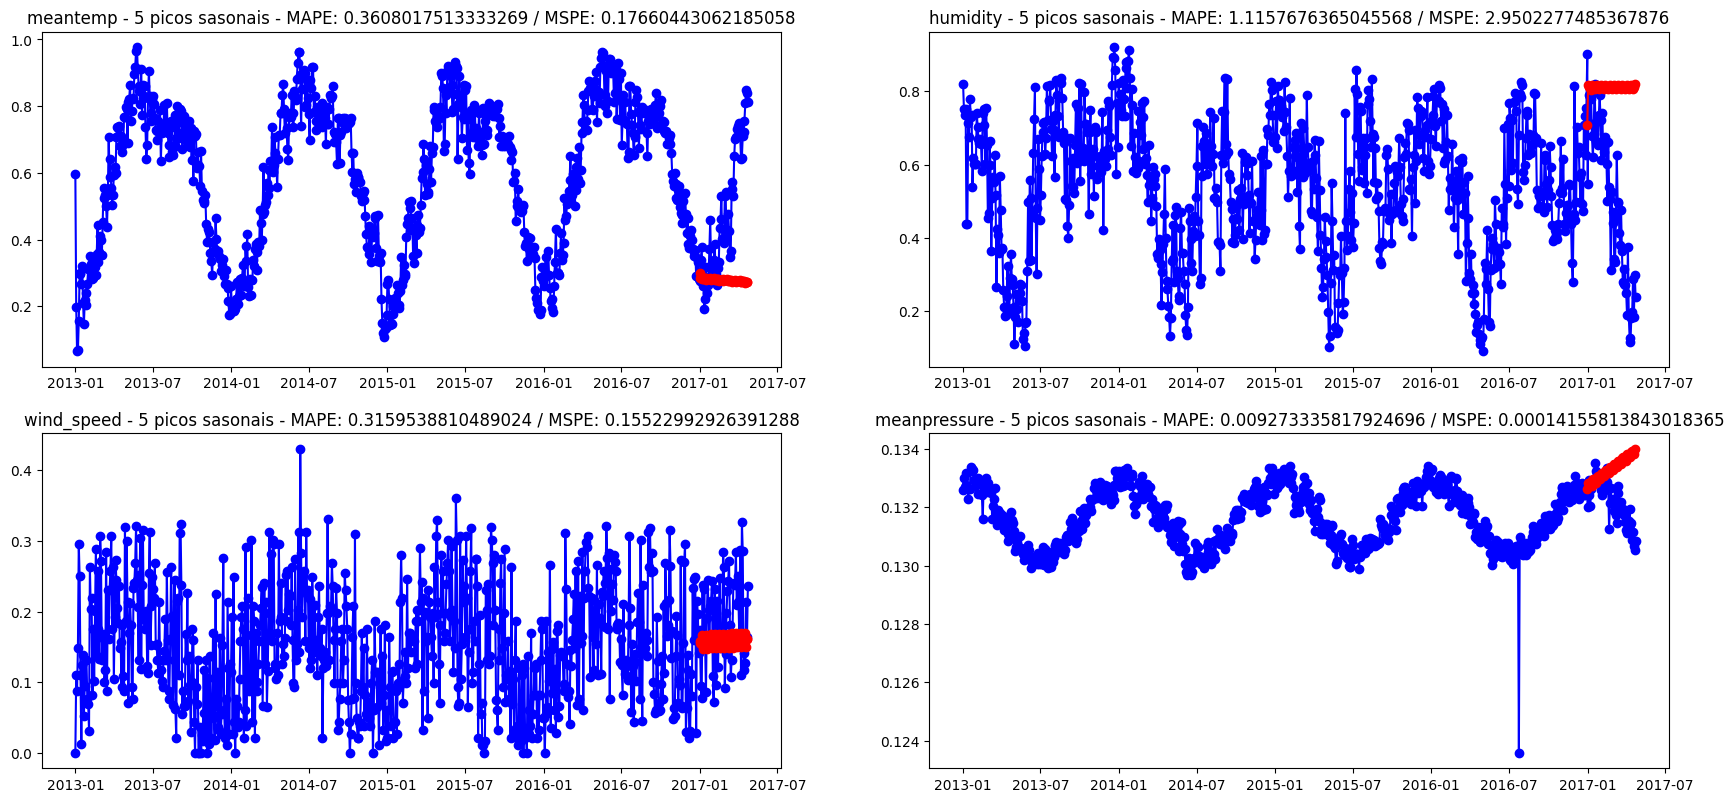

In [ ]:
test_ExpSmoothing(y_2D, y_train_2D, y_test_2D)

DONE: meantemp - 5 picos sasonais - MAPE: 0.9026465432093514 / MSPE: 1.014200672755175
DONE: humidity - 5 picos sasonais - MAPE: 1.0541369913760232 / MSPE: 2.8199532707420705
DONE: wind_speed - 5 picos sasonais - MAPE: 0.29839495117897885 / MSPE: 0.14842098708005727
DONE: meanpressure - 5 picos sasonais - MAPE: 0.008796526295263871 / MSPE: 0.00012807965781584923


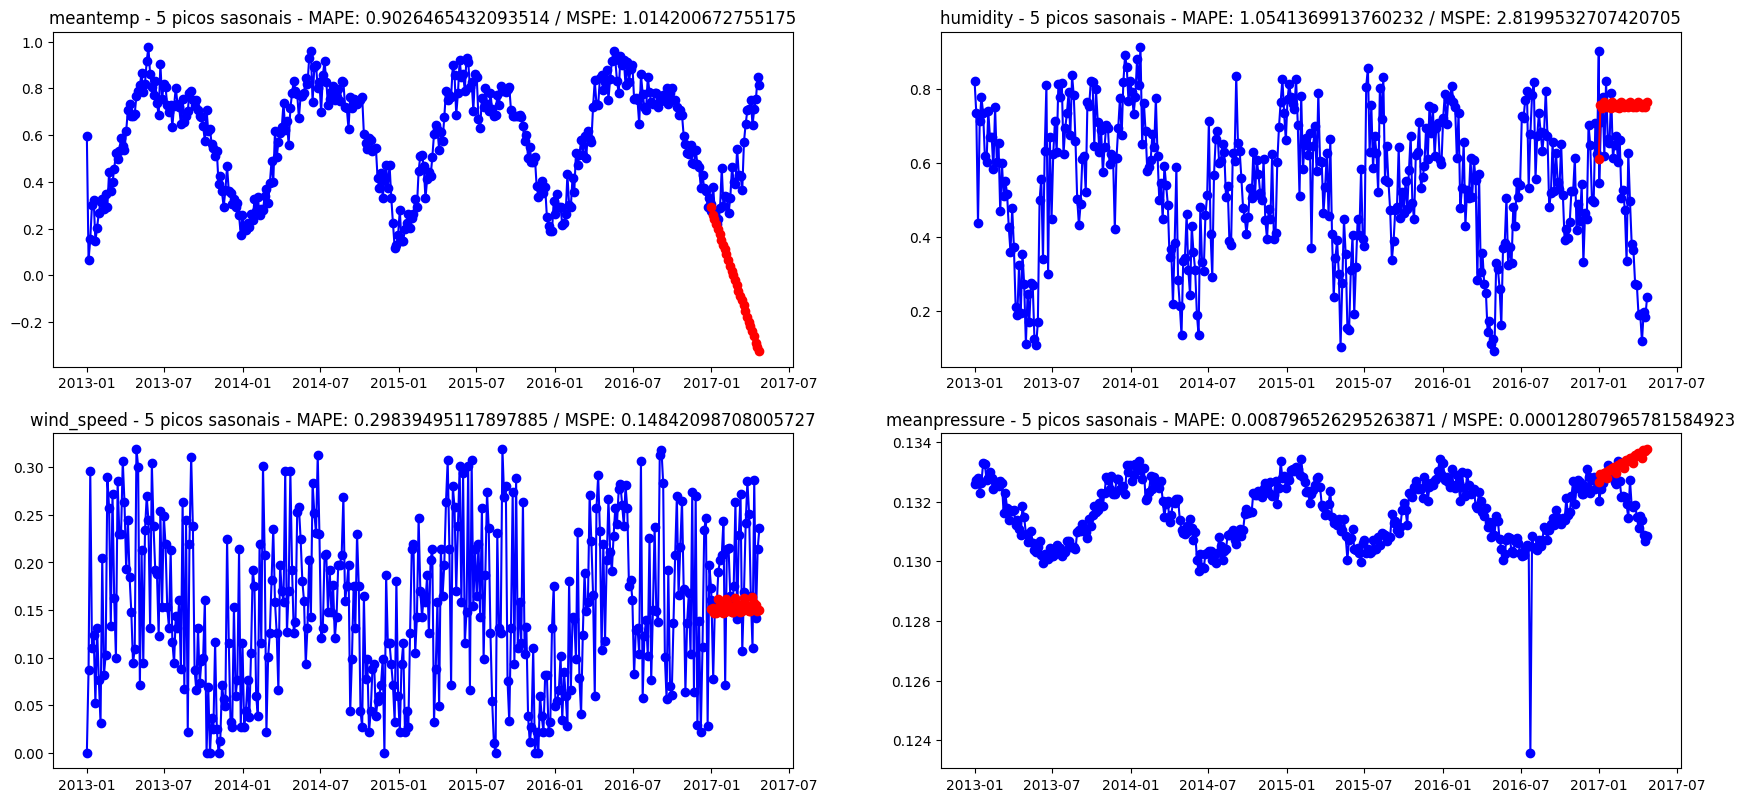

In [ ]:
test_ExpSmoothing(y_4D, y_train_4D, y_test_4D)

**Prophet**: Prophet é um procedimento para previsão de dados de séries temporais baseado em um modelo aditivo, no qual tendências não lineares são ajustadas com sazonalidade anual, semanal e diária, além de efeitos de feriados. Ele funciona melhor com séries temporais que possuem fortes efeitos sazonais e vários anos de dados históricos. O Prophet é robusto em relação a dados ausentes e mudanças na tendência, e geralmente lida bem com valores discrepantes.

In [ ]:
def test_Prophet(y_data, y_train_data, y_test_data):
  fig = plt.figure(figsize=(21, 20))

  y = y_data.copy()
  y.reset_index(inplace=True)
  y = y.rename(columns = {'date' : 'ds'})

  y_train = y_train_data.copy()
  y_train.reset_index(inplace=True)
  y_train = y_train.rename(columns = {'date' : 'ds'})

  y_test = y_test_data.copy()
  y_test.reset_index(inplace=True)
  y_test = y_test.rename(columns = {'date' : 'ds'})

  for i, col in enumerate(y_data.columns):
    y_aux = y.copy()
    y_aux = y_aux.rename(columns = {col: 'y'})
    y_train_aux = y_train.copy().rename(columns = {col:'y'})
    y_test_aux = y_test.copy().rename(columns = {col:'y'})


    forecaster = Prophet()
    forecaster.fit(y_train_aux)
    future_dates = pd.DataFrame()
    future_dates["ds"] = y_test_data.index
    y_last = forecaster.predict(future_dates)
    y_last['ds'] = pd.to_datetime(y_last['ds'])
    y_last.set_index('ds', inplace=True)

    title = col + " - MAPE: " + str(mean_absolute_percentage_error(y_test_data[col], y_last['yhat'])) + ' / MSPE: ' + str(mean_squared_percentage_error(y_test_data[col],  y_last['yhat']))
    print('DONE: ' + title)

    create_subplot(y_data[col], y_last['yhat'], len(y_data.columns)*100 + 20 + i + 1, title, fig)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx3cduwr1/yku269cw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx3cduwr1/c4vk5daf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=60340', 'data', 'file=/tmp/tmpx3cduwr1/yku269cw.json', 'init=/tmp/tmpx3cduwr1/c4vk5daf.json', 'output', 'file=/tmp/tmpx3cduwr1/prophet_modellwvj65zj/prophet_model-20230622003618.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:36:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
00:36:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx3

DONE: meantemp - MAPE: 0.1894365986127082 / MSPE: 0.06443397726613134


DEBUG:cmdstanpy:input tempfile: /tmp/tmpx3cduwr1/sqthgz0p.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=15772', 'data', 'file=/tmp/tmpx3cduwr1/qiszv0dy.json', 'init=/tmp/tmpx3cduwr1/sqthgz0p.json', 'output', 'file=/tmp/tmpx3cduwr1/prophet_modelily__3sn/prophet_model-20230622003618.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:36:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
00:36:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx3cduwr1/8s7gh8qq.json


DONE: humidity - MAPE: 0.29174303106387184 / MSPE: 0.22863421948100998


DEBUG:cmdstanpy:input tempfile: /tmp/tmpx3cduwr1/rgwp57al.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=17413', 'data', 'file=/tmp/tmpx3cduwr1/8s7gh8qq.json', 'init=/tmp/tmpx3cduwr1/rgwp57al.json', 'output', 'file=/tmp/tmpx3cduwr1/prophet_modeljpqvck09/prophet_model-20230622003619.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:36:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
00:36:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx3cduwr1/x4jwxx67.json


DONE: wind_speed - MAPE: 0.3316225097972228 / MSPE: 0.20273077436121992


DEBUG:cmdstanpy:input tempfile: /tmp/tmpx3cduwr1/78xoud8w.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=40670', 'data', 'file=/tmp/tmpx3cduwr1/x4jwxx67.json', 'init=/tmp/tmpx3cduwr1/78xoud8w.json', 'output', 'file=/tmp/tmpx3cduwr1/prophet_modelqvh_tvqo/prophet_model-20230622003619.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:36:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
00:36:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


DONE: meanpressure - MAPE: 0.002401097519486141 / MSPE: 9.688191523828663e-06


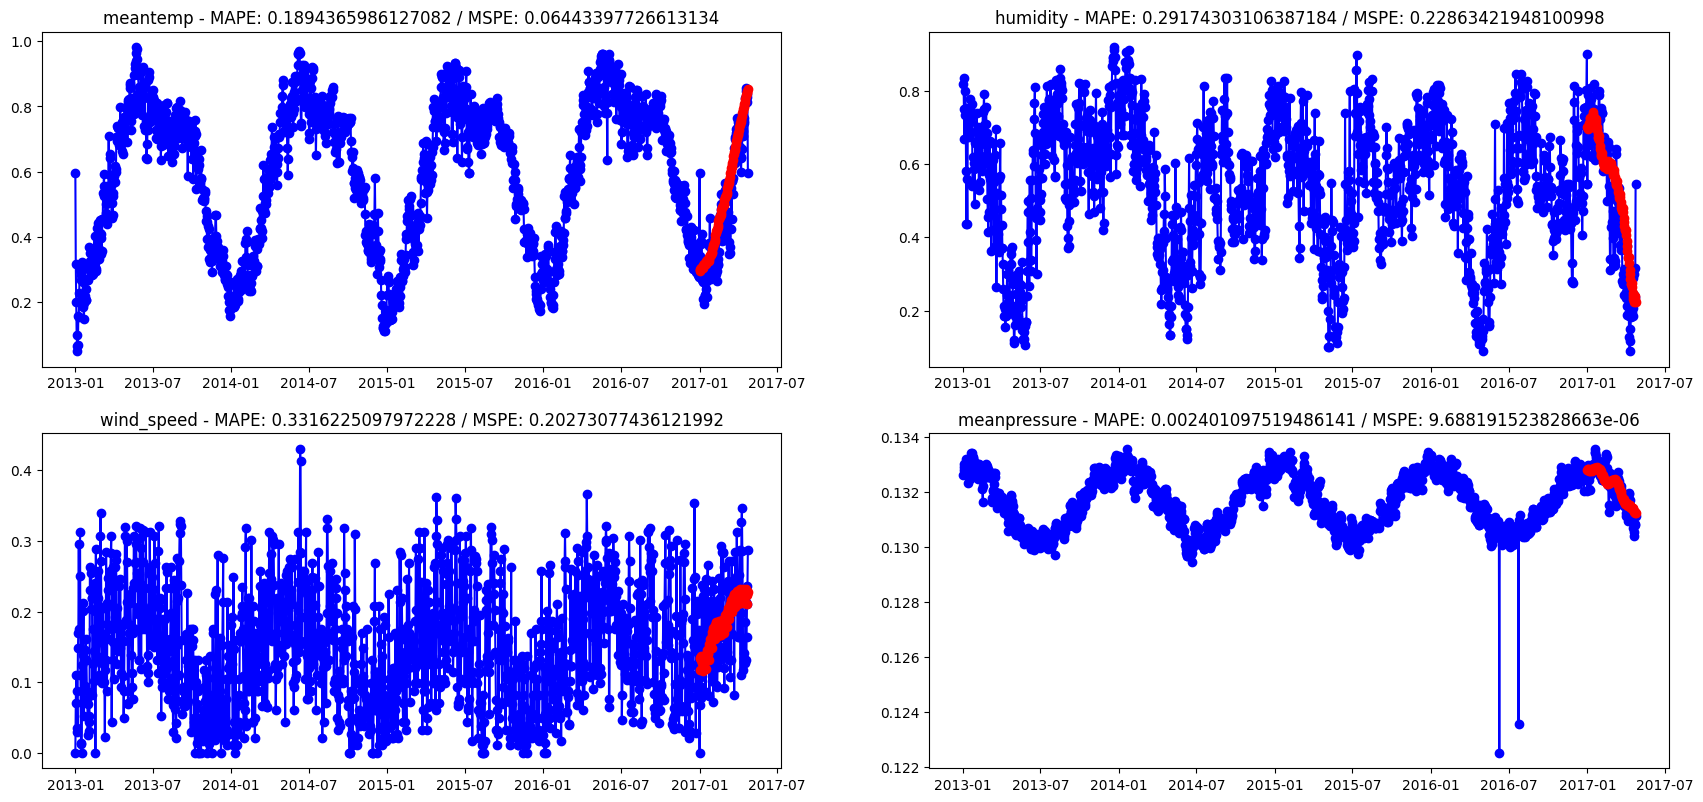

In [ ]:
test_Prophet(y_1D, y_train_1D,  y_test_1D)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx3cduwr1/6sntexja.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx3cduwr1/f3p36c5f.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=2668', 'data', 'file=/tmp/tmpx3cduwr1/6sntexja.json', 'init=/tmp/tmpx3cduwr1/f3p36c5f.json', 'output', 'file=/tmp/tmpx3cduwr1/prophet_modeldub_2m32/prophet_model-20230622003622.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:36:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
00:36:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx3c

DONE: meantemp - MAPE: 0.1672977236010374 / MSPE: 0.05394244256594437


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx3cduwr1/j0iqjy1m.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx3cduwr1/hlmir1vb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=5276', 'data', 'file=/tmp/tmpx3cduwr1/j0iqjy1m.json', 'init=/tmp/tmpx3cduwr1/hlmir1vb.json', 'output', 'file=/tmp/tmpx3cduwr1/prophet_modelwkaq842k/prophet_model-20230622003623.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:36:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
00:36:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


DONE: humidity - MAPE: 0.27610779476665603 / MSPE: 0.1839643073482206


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx3cduwr1/_s80vdl5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx3cduwr1/_6_fz3xq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=5430', 'data', 'file=/tmp/tmpx3cduwr1/_s80vdl5.json', 'init=/tmp/tmpx3cduwr1/_6_fz3xq.json', 'output', 'file=/tmp/tmpx3cduwr1/prophet_modelb483xl4h/prophet_model-20230622003623.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:36:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


DONE: wind_speed - MAPE: 0.33580980620682704 / MSPE: 0.1800399784933377


00:36:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


DONE: meanpressure - MAPE: 0.0025092899856524113 / MSPE: 1.0171600182809823e-05


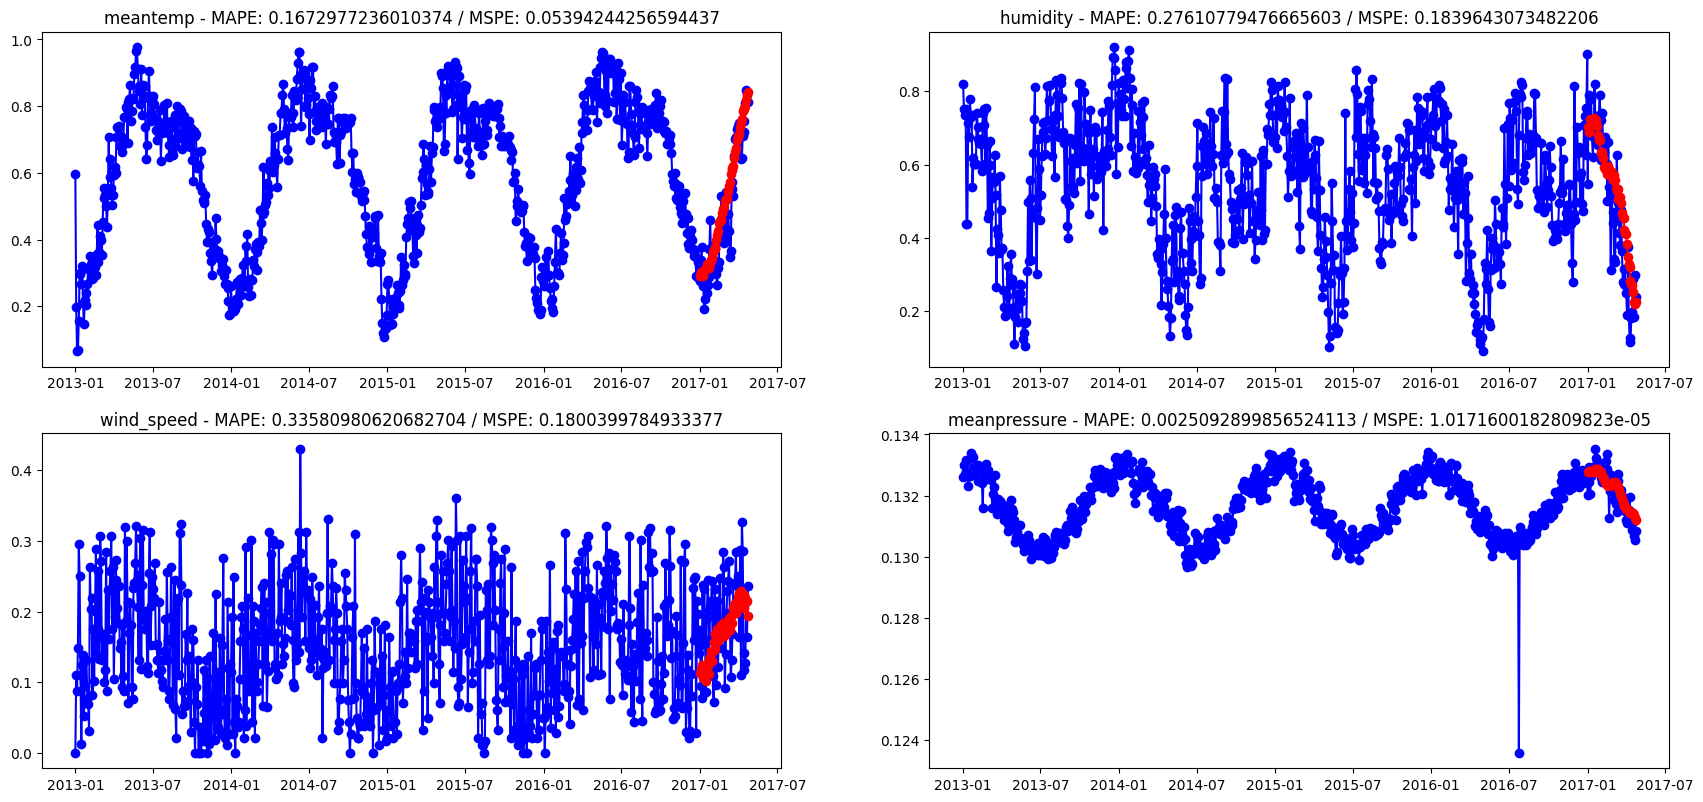

In [ ]:
test_Prophet(y_2D, y_train_2D,  y_test_2D)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx3cduwr1/efdisxds.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx3cduwr1/36k4_egl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=48346', 'data', 'file=/tmp/tmpx3cduwr1/efdisxds.json', 'init=/tmp/tmpx3cduwr1/36k4_egl.json', 'output', 'file=/tmp/tmpx3cduwr1/prophet_model39grhl8y/prophet_model-20230622003625.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:36:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
00:36:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx3

DONE: meantemp - MAPE: 0.16519675931080757 / MSPE: 0.05185250672938112
DONE: humidity - MAPE: 0.292256347930688 / MSPE: 0.21004395772730958


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx3cduwr1/kzb0uqin.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx3cduwr1/efua1ov5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=77604', 'data', 'file=/tmp/tmpx3cduwr1/kzb0uqin.json', 'init=/tmp/tmpx3cduwr1/efua1ov5.json', 'output', 'file=/tmp/tmpx3cduwr1/prophet_modelltvx62g3/prophet_model-20230622003625.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:36:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
00:36:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx3

DONE: wind_speed - MAPE: 0.3502492452410067 / MSPE: 0.18317213812624522


DEBUG:cmdstanpy:input tempfile: /tmp/tmpx3cduwr1/qz307f2r.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=21553', 'data', 'file=/tmp/tmpx3cduwr1/36anpsda.json', 'init=/tmp/tmpx3cduwr1/qz307f2r.json', 'output', 'file=/tmp/tmpx3cduwr1/prophet_modellof1bfzx/prophet_model-20230622003626.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:36:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
00:36:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


DONE: meanpressure - MAPE: 0.0023847595884619183 / MSPE: 9.400396896258433e-06


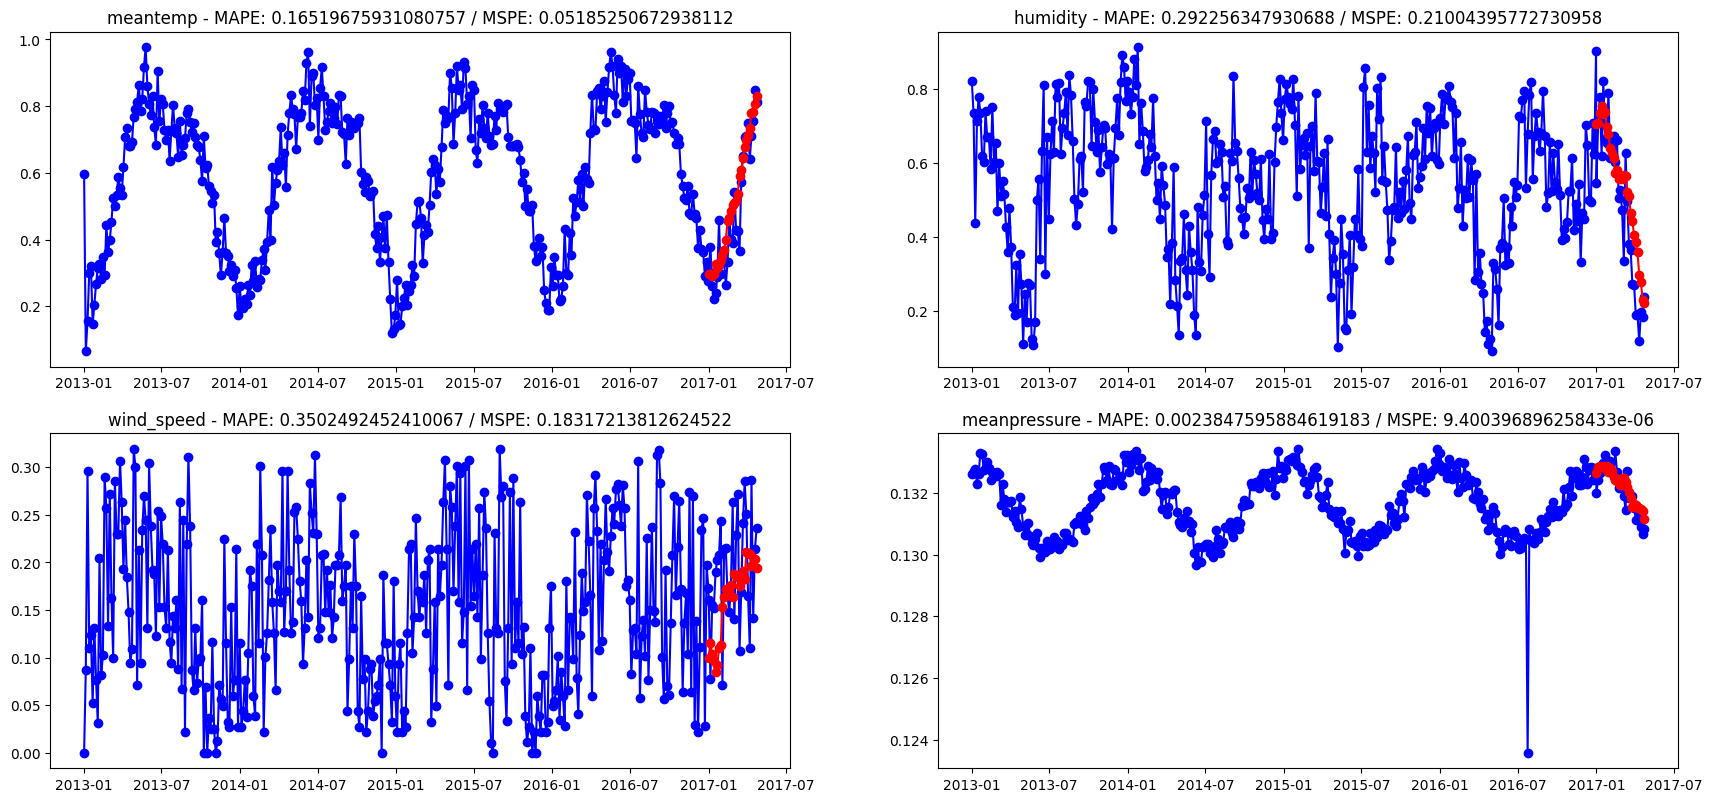

In [ ]:
test_Prophet(y_4D, y_train_4D,  y_test_4D)

---
# **3. Interpretação dos resultados obtidos**

## **3.1. Resultados**

### **3.1.1. AutoARIMA**
Os resultados obtidos para os três dadtasets de teste com o algoritimo AutoARIMA foram:

* **Frequência: 1 dia:**
  * **meantemp** - MAPE: 0.3624294260805139 / MSPE: 0.20000784190683463
  * **humidity** - MAPE: 0.6096968881899325 / MSPE: 1.086235677268269
  * **wind_speed** - MAPE: 0.3176432713950525 / MSPE: 0.1336658356045566
  * **meanpressure** - MAPE: 0.0037042091407261577 / MSPE: 1.9866887019259007e-05

* **Frquência: 2 dias:**
  * **meantemp** - MAPE: 0.25743432827626245 / MSPE: 0.09387762043538728
  * **humidity** - MAPE: 0.6133155919582816 / MSPE: 1.0830259656259822
  * **wind_speed** - MAPE: 0.33051470306055225 / MSPE: 0.1642953282961248
  * **meanpressure** - MAPE: 0.003661390699348607 / MSPE: 1.963003761603486e-05

* **Frequência: 4 dias:**
  * **meantemp** - MAPE: 0.17874528920822547 / MSPE: 0.043995468483553145
  * **humidity** - MAPE: 0.6813326839147711 / MSPE: 1.3216456163308492
  * **wind_speed** - MAPE: 0.30345156696473014 / MSPE: 0.1545906209876034
  * **meanpressure** - MAPE: 0.00427101243470001 / MSPE: 2.6665862945776454e-05


### **3.1.2. Exponential Smoothing**
Os resultados obtidos para os três dadtasets de teste com o algoritimo Exponential Smoothing foram:

* **Frequência: 1 dia:**
  * **meantemp** - MAPE: 0.493213151706601 / MSPE: 0.41449194134433054
  * **humidity** - MAPE: 0.6250695598136046 / MSPE: 1.1106985271860175
  * **wind_speed** -  MAPE: 0.4946665485937959 / MSPE: 0.28000576651154774
  * **meanpressure** -  MAPE: 0.00884528249338712 / MSPE: 0.00012896554837503793

* **Frquência: 2 dias:**
  * **meantemp** - MAPE: 0.3608017513333269 / MSPE: 0.17660443062185058
  * **humidity** - MAPE: 1.1157676365045568 / MSPE: 2.9502277485367876
  * **wind_speed** - MAPE: 0.3159538810489024 / MSPE: 0.15522992926391288
  * **meanpressure** - MAPE: 0.009273335817924696 / MSPE: 0.00014155813843018365

* **Frequência: 4 dias:**
  * **meantemp** - MAPE: 0.9026465432093514 / MSPE: 1.014200672755175
  * **humidity** - MAPE: 1.0541369913760232 / MSPE: 2.8199532707420705
  * **wind_speed** - MAPE: 0.29839495117897885 / MSPE: 0.14842098708005727
  * **meanpressure** - MAPE: 0.008796526295263871 / MSPE: 0.00012807965781584923


### **3.1.3. Prophet**
* **Frequência: 1 dia:**
  * **meantemp** - MAPE: 0.1894365986127082 / MSPE: 0.06443397726613134
  * **humidity** - MAPE: 0.29174303106387184 / MSPE: 0.22863421948100998
  * **wind_speed** -  MAPE: 0.3316225097972228 / MSPE: 0.20273077436121992
  * **meanpressure** -  MAPE: 0.002401097519486141 / MSPE: 9.688191523828663e-06

* **Frquência: 2 dias:**
  * **meantemp** - MAPE: 0.1672977236010374 / MSPE: 0.05394244256594437
  * **humidity** - MAPE: 0.27610779476665603 / MSPE: 0.1839643073482206
  * **wind_speed** - MAPE: 0.33580980620682704 / MSPE: 0.1800399784933377
  * **meanpressure** - MAPE: 0.0025092899856524113 / MSPE: 1.0171600182809823e-05

* **Frequência: 4 dias:**
  * **meantemp** - MAPE: 0.16519675931080757 / MSPE: 0.05185250672938112
  * **humidity** - MAPE: 0.292256347930688 / MSPE: 0.21004395772730958
  * **wind_speed** - MAPE: 0.3502492452410067 / MSPE: 0.18317213812624522
  * **meanpressure** - MAPE: 0.0023847595884619183 / MSPE: 9.400396896258433e-06


## **3.1. Frequência dos dados**
O aumento do intervalo entre dados consecultivos gerou uma diminuição dos erros proporcionais em todos os algoritimos, isso pode se dar ao fato de que os dados contém informações climáticas, que medem grandezas com variações à longo prazo, portanto a redução da frequência pode reduzir o ruído de curto prazo e fortalecer as sazonalidades de períodos mais longos.

## **3.2. Desempenho dos algoritimos**
Os algoritimos de autoARIMA e Exponential Smoothing apresentaram resultados bastante inferiores ao algoritimo Prophet. Isso pode ser devido ao número de picos sasonais escolhido que foi inferior ao valor ótimo. O algoritimo autoARIMA obteve melhores resultados porém o seu tempo de execussão também é bastante superior, de forma que para valores elevados do número de picos asonais o algoritimo autoARIMA toma um tempo bastante significativo e consome uma quantidade excessiva de recursos computacionais, o que pode inviabilizar a sua utilização, fazendo o Exponential Smoothing preferível.

O algoritimo Prophet apresentou o melhor desempenho em questão da sua capacidade de previsão e em relação ao consumo de recursos computacionais, sendo um algoritimo extremamente rápido e preciso.

---
# 4. Conclusão
A partir dos dados é seguro concluir que o algoritimo Prophet é o amis recomendado para essa aplicação, pois além de obter resultados excelentes, ele o faz com um baixo custo computacional associado. Os algoritimos de autoARIMA e Exponential Smoothing